In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
import sklearn.cluster
import sklearn.linear_model
from sklearn import datasets, linear_model
from sklearn.svm import SVR
%matplotlib inline

In [2]:
#specify data source 
datasource = 'L'

In [3]:
#zipcode = '92562'
zipcode = '08641'

In [4]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [5]:
data = pd.read_csv(dataDir +'/training_data_fitted_adjusted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [6]:
weatherdatasource = '/data/weather/weathersource/hourly/'
if (zipcode == '08641')|(zipcode =='08640'):
    weatherdata = pd.read_csv(mainDir+weatherdatasource+'08641_20132014.csv')
if (zipcode == '92562')|(zipcode =='92563'):
    weatherdata = pd.read_csv(mainDir+weatherdatasource+'92563_20132014.csv')

weatherdata['tsLocal'] = weatherdata.timestamp.map(lambda x: x[0:10] + " " + x[11:19])
#weatherdata.tsLocal = weatherdata.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
if type(weatherdata.tsLocal[0])==str:
    weatherdata['tsLocal'] = weatherdata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
weatherdata.drop(['timestamp','country','postal_code'], axis=1, inplace=True)

In [7]:
if weatherdata.shape[0]!=len(set(weatherdata['tsLocal'])):
    for i in range(weatherdata.shape[0]):
        if weatherdata.loc[i,'tsLocal'] == weatherdata.loc[(i+1),'tsLocal']:
            print weatherdata.loc[i,'tsLocal']

In [8]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,4.742651


In [9]:
FullModelCoef[:1]

,DBW,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,0,0.146378,0.415993,0.488299,0.645738,0.714671,0.729269,0.760784,0.76581,0.660012,0.647527,0.141794


In [10]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:30:00,1.11014,-301.362934,NaN,5,64.71819,-0.999743,-355,0.296,NaN,0.415969


# Basic time series construction with hourly volatility

Here we construct time series of power and power ratio. We add time without sun to create consistent time series. In addition, we add parallel values of previous 15 minute instances (-1, -2, ...) and previous day instances (y).

In [11]:
#specify scope
StartScopeDate = '2013-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
        
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,weatherdata,on=['tsLocal'], how = 'left') 

In [12]:
d.shape

(70080, 12)

In [13]:
for j in range(1,12):
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
        #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

In [14]:
#Now we can merge our backbone + weather with solar data
d = pd.merge(d,data,on=['tsLocal'], how = 'left') 

In [15]:
#timeseries of previous timestamps
d['power-1'] = float('NaN')
d['mpower-1'] = float('NaN')
d['mpower-2'] = float('NaN')
d['mpower-3'] = float('NaN')
d['mpower-4'] = float('NaN')
d['power-2'] = float('NaN')
d['power-3'] = float('NaN')
d['power-4'] = float('NaN')
d['power-5'] = float('NaN')
d['power-6'] = float('NaN')
d['power_y-0'] = float('NaN')
d['power_y-1'] = float('NaN')
d['power_y-2'] = float('NaN')
d['r-1'] = float('NaN')
d['r-2'] = float('NaN')
d['r-3'] = float('NaN')
d['r-4'] = float('NaN')
d['r-5'] = float('NaN')
d['r-6'] = float('NaN')
d['r_y-0'] = float('NaN')
d['r_y-1'] = float('NaN')
d['r_y-2'] = float('NaN')
d.loc[1:d.shape[0],'r-1'] = list(d['r'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'r-2'] = list(d['r'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'r-3'] = list(d['r'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'r-4'] = list(d['r'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'r-5'] = list(d['r'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'r-6'] = list(d['r'].iloc[0:(d.shape[0]-6)])
d.loc[1:d.shape[0],'mpower-1'] = list(d['mpower'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'mpower-2'] = list(d['mpower'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'mpower-3'] = list(d['mpower'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'mpower-4'] = list(d['mpower'].iloc[0:(d.shape[0]-4)])
d.loc[1:d.shape[0],'power-1'] = list(d['power'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'power-2'] = list(d['power'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'power-3'] = list(d['power'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'power-4'] = list(d['power'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'power-5'] = list(d['power'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'power-6'] = list(d['power'].iloc[0:(d.shape[0]-6)])

#24 hour shift = 24*4 shift in index. 'y' means yesterday
d.loc[96:d.shape[0],'r_y-0'] = list(d['r'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-1'] = list(d['r-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-2'] = list(d['r-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-3'] = list(d['r-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-4'] = list(d['r-4'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-0'] = list(d['power'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-1'] = list(d['power-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-2'] = list(d['power-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-3'] = list(d['power-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-4'] = list(d['power-4'].iloc[0:(d.shape[0]-96)])

In [16]:
d['cldCvr-1'] = float('NaN')
d['dewPt-1'] = float('NaN')
d['feelsLike-1'] = float('NaN')
d['precip-1'] = float('NaN')
d['relHum-1'] = float('NaN')
d['sfcPres-1'] = float('NaN')
d['snowfall-1'] = float('NaN')
d['spcHum-1'] = float('NaN')
d['temp-1'] = float('NaN')
d['windSpd-1'] = float('NaN')
d['wetBulb-1'] = float('NaN')
d.loc[1:d.shape[0],'cldCvr-1'] = list(d['cldCvr'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'dewPt-1'] = list(d['dewPt'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'feelsLike-1'] = list(d['feelsLike'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'precip-1'] = list(d['precip'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'relHum-1'] = list(d['relHum'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'sfcPres-1'] = list(d['sfcPres'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'snowfall-1'] = list(d['snowfall'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'spcHum-1'] = list(d['spcHum'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'temp-1'] = list(d['temp'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'windSpd-1'] = list(d['windSpd'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'wetBulb-1'] = list(d['wetBulb'].iloc[0:(d.shape[0]-1)])

In [17]:
#normalize weather value
d['cldCvr-1'] = (d['cldCvr-1']-np.min(d['cldCvr-1']))/(np.max(d['cldCvr-1'])-np.min(d['cldCvr-1']))
d['dewPt-1'] = (d['dewPt-1']-np.min(d['dewPt-1']))/(np.max(d['dewPt-1'])-np.min(d['dewPt-1']))
d['feelsLike-1'] = (d['feelsLike-1']-np.min(d['feelsLike-1']))/(np.max(d['feelsLike-1'])-np.min(d['feelsLike-1']))
d['precip-1'] = (d['precip-1']-np.min(d['precip-1']))/(np.max(d['precip-1'])-np.min(d['precip-1']))
d['relHum-1'] = (d['relHum-1']-np.min(d['relHum-1']))/(np.max(d['relHum-1'])-np.min(d['relHum-1']))
d['sfcPres-1'] = (d['sfcPres-1']-np.min(d['sfcPres-1']))/(np.max(d['sfcPres-1'])-np.min(d['sfcPres-1']))
d['snowfall-1'] = (d['snowfall-1']-np.min(d['snowfall-1']))/(np.max(d['snowfall-1'])-np.min(d['snowfall-1']))
d['spcHum-1'] = (d['spcHum-1']-np.min(d['spcHum-1']))/(np.max(d['spcHum-1'])-np.min(d['spcHum-1']))
d['temp-1'] = (d['temp-1']-np.min(d['temp-1']))/(np.max(d['temp-1'])-np.min(d['temp-1']))
d['windSpd-1'] = (d['windSpd-1']-np.min(d['windSpd-1']))/(np.max(d['windSpd-1'])-np.min(d['windSpd-1']))
d['wetBulb-1'] = (d['wetBulb-1']-np.min(d['wetBulb-1']))/(np.max(d['wetBulb-1'])-np.min(d['wetBulb-1']))


Let's compute rolling hourly volaitility (this is for 15 min interval)

In [18]:
#volatility derivative-based and persistence-based
#d['V-d'] = np.absolute(d['power-1']-4*d['power-2']+6*d['power-3']-4*d['power-4']+d['power-5'])
d['V-s'] = np.absolute(d['power-1']-d['power-2']/d['mpower-2']*d['mpower-1'])+\
            np.absolute(d['power-2']-d['power-3']/d['mpower-3']*d['mpower-2'])+\
             np.absolute(d['power-3']-d['power-4']/d['mpower-4']*d['mpower-3'])

Here we separate data for training and testing. Need this for autoregressive model.

In [19]:
Data = d
#select data for training and test
StartDate = datetime.date(2014,10,1)
TrainData = d[d.tsLocal.map(lambda x: x.date()) <StartDate].set_index('tsLocal')
TrainDateList = list(dsummary.Date[dsummary.Date<StartDate])
TestData = d[d.tsLocal.map(lambda x: x.date()) >=StartDate].set_index('tsLocal')

#Extra screening by high energy days
HighEnergyDayList = list(dsummary.Date[dsummary.E/dsummary.mE>0.9]) #for NJ
HighEnergyTestData = d[d.tsLocal.map(lambda x: (x.date()>=StartDate) & (x.date() in HighEnergyDayList))].set_index('tsLocal')

#15-minute rolling prediction

Before doing any model, make a consistent train/test by randomly assign 80/20

In [20]:
d = Data
#Truly random
#l = np.random.permutation(d.shape[0])
#d = d.iloc[l].reset_index(drop=True)
#offset = int(d.shape[0] * 0.8)

#Assign specific period
StartDate = datetime.date(2014,10,1)
offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

Data_train = d[:offset]
Data_test = d[offset:]

In [21]:
Data.shape

(70080, 60)

In [22]:
#For bin reference
numbins = int(math.ceil(np.max(d['V-s'])/0.1))
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
middlebinvalue = [0.1*i+0.05 for i in range(0,numbins)]

## Prediction for zeroth method

In [23]:
Data['power_predict_zeroth'] = float('NaN')

In [24]:
feature_names = ['expectedr']

DateOfInterest = StartDate 

while DateOfInterest < EndScopeTime.date():
#if(1==1):
    
    #print(DateOfInterest)

    d_imm = Data.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()

    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()==DateOfInterest)]

    d['power_predict'] = d.loc[:,'expectedr']*d.loc[:,'mpower']
    d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
    d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)

    #add it into Data
    Data.loc[d.index,'power_predict_zeroth'] = d['power_predict']
    #update date
    DateOfInterest = DateOfInterest + datetime.timedelta(days=1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [25]:
len(Data['power_predict_zeroth'].dropna())/90. #number of training points per day 

41.422222222222224

## Prediction for GBR with set II

In [26]:
#GBR
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

In [27]:
Data['power_predict_GBR_set2'] = float('NaN')

In [28]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
'''
    feature_names = feature_names + ['V-s']
if zipcode == '08641':
    feature_names = ['r-1']
    feature_names = feature_names + ['s','DBW']
    feature_names = feature_names + ['V-s']
    feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']
'''

"\n    feature_names = feature_names + ['V-s']\nif zipcode == '08641':\n    feature_names = ['r-1']\n    feature_names = feature_names + ['s','DBW']\n    feature_names = feature_names + ['V-s']\n    feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',\n                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']\n"

In [29]:
DateOfInterest = StartDate 

while DateOfInterest < EndScopeTime.date():
    
    #print(DateOfInterest)
    
    d_imm = Data.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()<DateOfInterest)]
    X_train, y_train = d.loc[:,feature_names], d.loc[:,'r']
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()==DateOfInterest)]
    X_test, y_test = d.loc[:,feature_names], d.loc[:,'r']
    
    clf.fit(X_train, y_train)

    d['power_predict'] = (clf.predict(X_test))*d.loc[:,'mpower']
    d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
    d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)

    #add it into Data
    Data.loc[d.index,'power_predict_GBR_set2'] = d['power_predict']
    #update date
    DateOfInterest = DateOfInterest + datetime.timedelta(days=1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [30]:
len(Data['power_predict_GBR_set2'].dropna())/90. #number of training points per day 

40.4

## Prediction for GBR with set III

In [31]:
Data['power_predict_GBR_set3'] = float('NaN')

In [32]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names + ['V-s']
'''
    
if zipcode == '08641':
    feature_names = ['r-1']
    feature_names = feature_names + ['s','DBW']
    feature_names = feature_names + ['V-s']
    feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']
'''

"\n    \nif zipcode == '08641':\n    feature_names = ['r-1']\n    feature_names = feature_names + ['s','DBW']\n    feature_names = feature_names + ['V-s']\n    feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',\n                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']\n"

In [33]:
DateOfInterest = StartDate 

while DateOfInterest < EndScopeTime.date():
    
    #print(DateOfInterest)
    
    d_imm = Data.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()<DateOfInterest)]
    X_train, y_train = d.loc[:,feature_names], d.loc[:,'r']
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()==DateOfInterest)]
    X_test, y_test = d.loc[:,feature_names], d.loc[:,'r']
    
    clf.fit(X_train, y_train)

    d['power_predict'] = (clf.predict(X_test))*d.loc[:,'mpower']
    d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
    d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)

    #add it into Data
    Data.loc[d.index,'power_predict_GBR_set3'] = d['power_predict']
    #update date
    DateOfInterest = DateOfInterest + datetime.timedelta(days=1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [34]:
len(Data['power_predict_GBR_set3'].dropna())/90. #number of training points per day 

37.333333333333336

## Prediction for GBR with set IV

In [35]:
Data['power_predict_GBR_set4'] = float('NaN')

In [36]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

In [37]:
DateOfInterest = StartDate 

while DateOfInterest < EndScopeTime.date():
    
    #print(DateOfInterest)
    
    d_imm = Data.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()<DateOfInterest)]
    X_train, y_train = d.loc[:,feature_names], d.loc[:,'r']
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()==DateOfInterest)]
    X_test, y_test = d.loc[:,feature_names], d.loc[:,'r']
    
    clf.fit(X_train, y_train)

    d['power_predict'] = (clf.predict(X_test))*d.loc[:,'mpower']
    d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
    d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)

    #add it into Data
    Data.loc[d.index,'power_predict_GBR_set4'] = d['power_predict']
    #update date
    DateOfInterest = DateOfInterest + datetime.timedelta(days=1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [38]:
len(Data['power_predict_GBR_set4'].dropna())/90. #number of training points per day 

40.32222222222222

## Prediction for GBR with set V


In [39]:
Data['power_predict_GBR_set5'] = float('NaN')

In [40]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names + ['V-s']
feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

In [41]:
DateOfInterest = StartDate 

while DateOfInterest < EndScopeTime.date():
    
    #print(DateOfInterest)
    
    d_imm = Data.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()<DateOfInterest)]
    X_train, y_train = d.loc[:,feature_names], d.loc[:,'r']
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()==DateOfInterest)]
    X_test, y_test = d.loc[:,feature_names], d.loc[:,'r']
    
    clf.fit(X_train, y_train)

    d['power_predict'] = (clf.predict(X_test))*d.loc[:,'mpower']
    d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
    d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)

    #add it into Data
    Data.loc[d.index,'power_predict_GBR_set5'] = d['power_predict']
    #update date
    DateOfInterest = DateOfInterest + datetime.timedelta(days=1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [42]:
len(Data['power_predict_GBR_set5'].dropna())/90. #number of training points per day 

37.25555555555555

In [43]:
'''
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist_zeroth,color='red',label='max_zeroth',linestyle='--')
ax1.plot(middlebinvalue,meandifflist_zeroth,color='blue',label = 'mean_zeroth',linestyle='--')
ax1.plot(middlebinvalue,maxdifflist_persistent,color='red',label='max_persistent',linestyle=':')
ax1.plot(middlebinvalue,meandifflist_persistent,color='blue',label = 'mean_persistent',linestyle=':')
ax1.plot(middlebinvalue,maxdifflist_GBR,color='red',label='max_GBR')
ax1.plot(middlebinvalue,meandifflist_GBR,color='blue',label = 'mean_GBR')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()'''

"\nfig = plt.figure(figsize=(10,6))\nax1  = fig.add_subplot(111)\n\nax1.plot(middlebinvalue,maxdifflist_zeroth,color='red',label='max_zeroth',linestyle='--')\nax1.plot(middlebinvalue,meandifflist_zeroth,color='blue',label = 'mean_zeroth',linestyle='--')\nax1.plot(middlebinvalue,maxdifflist_persistent,color='red',label='max_persistent',linestyle=':')\nax1.plot(middlebinvalue,meandifflist_persistent,color='blue',label = 'mean_persistent',linestyle=':')\nax1.plot(middlebinvalue,maxdifflist_GBR,color='red',label='max_GBR')\nax1.plot(middlebinvalue,meandifflist_GBR,color='blue',label = 'mean_GBR')\n#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')\nax1.set_xlabel('volatiliy of the most recent hour')\nax1.set_ylabel('prediction difference')\nax1.set_ylim(0,0.7)\nax1.legend()"

In [44]:
Data.power_predict_GBR_set2.dropna()

61277    0.107850
61278    0.115774
61279    0.128605
61280    0.153980
61281    0.174348
61282    0.160391
61283    0.160830
61284    0.199237
61285    0.264320
61286    0.280123
61287    0.243412
61288    0.261164
61289    0.221737
61290    0.198247
61291    0.232566
...
70036    0.713588
70037    0.699432
70038    0.665941
70039    0.643260
70040    0.618186
70041    0.590956
70042    0.542189
70043    0.490787
70044    0.429985
70045    0.377083
70046    0.318792
70047    0.256930
70048    0.203333
70049    0.144494
70050    0.109799
Name: power_predict_GBR_set2, Length: 3636, dtype: float64

In [45]:
Data['power_predict_final'] = float('NaN')
if zipcode == '92562':
    #background prediction
    Data['power_predict_final'] = Data['power_predict_zeroth']
    
    d = Data.loc[:,['power_predict_GBR_set2']].dropna()
    Data.loc[d.index,'power_predict_final'] = d['power_predict_GBR_set2']
    
    d = Data.loc[:,['power_predict_GBR_set3']].dropna()
    Data.loc[d.index,'power_predict_final'] = d['power_predict_GBR_set3']
    
    #against high volatility
    d = Data.loc[:,['V-s','power_predict_zeroth']].dropna()
    d = d[d['V-s']>0.6]
    Data.loc[d.index,'power_predict_final'] = d['power_predict_zeroth']
    
if zipcode == '08641':
    #background prediction
    Data['power_predict_final'] = Data['power_predict_zeroth']
    
    d = Data.loc[:,['power_predict_GBR_set2']].dropna()
    Data.loc[d.index,'power_predict_final'] = d['power_predict_GBR_set2']
    
    d = Data.loc[:,['power_predict_GBR_set3']].dropna()
    Data.loc[d.index,'power_predict_final'] = d['power_predict_GBR_set3']
    
    d = Data.loc[:,['power_predict_GBR_set4']].dropna()
    Data.loc[d.index,'power_predict_final'] = d['power_predict_GBR_set4']
    
    d = Data.loc[:,['power_predict_GBR_set5']].dropna()
    Data.loc[d.index,'power_predict_final'] = d['power_predict_GBR_set5']
    
    #against high volatility
    d = Data.loc[:,['V-s','power_predict_zeroth']].dropna()
    d = d[d['V-s']>0.6]
    Data.loc[d.index,'power_predict_final'] = d['power_predict_zeroth']


In [46]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

-0.000747053438848 0.0493623843891
(-0.00020713017676823753, 0.028166626868036147)


C:\Users\Admin\Anaconda\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


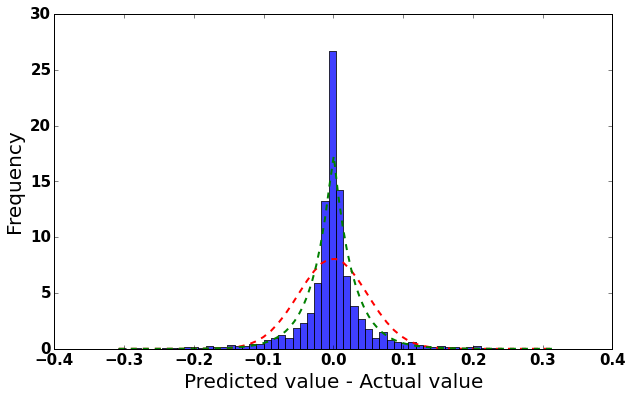

In [47]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats

fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
#Overall distribution

l = list((Data['power_predict_final']-Data['power']).dropna())


# the histogram of the data
n, bins, patches = ax1.hist(l, 60, normed=1, alpha=0.75)

# best fit of data with normal distribution
(mu, sigma) = norm.fit(l)
print mu, sigma

plt.xlabel("Predicted value - Actual value")
plt.ylabel("Frequency")


# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
ax1.plot(bins, y, 'r--', linewidth=2)

laplace = stats.laplace

# fit
param = laplace.fit(l)
x = np.linspace(np.min(l), np.max(l), 100)
pdf_fitted = laplace.pdf(x, *param)
plt.plot(x, pdf_fitted, 'g--', linewidth=2)

print  param


In [48]:
len(l), np.mean(np.absolute(l)), np.max(np.absolute(l)), np.mean(Data['power'].dropna())

(3728, 0.028163275906090943, 0.31501802323238803, 0.38603065955808491)

In [49]:
Data.to_csv(dataDir +'/data_with_full_forecast.csv',index=False)